In [34]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, udf, when
from pyspark.sql.types import StringType, IntegerType
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud

I**nitialising spark session**

In [2]:
spark = SparkSession.builder \
    .appName("CustomerFeedbackAnalysis") \
    .getOrCreate()

**Reading csv data**

In [6]:
df = spark.read.csv("/feedback_data.csv", header=True, inferSchema=True)
df.show(5)

+-----------+----------------+------+--------------------+----------+
|Customer ID|Feedback Channel|Rating|             Comment|      Date|
+-----------+----------------+------+--------------------+----------+
|     C43875|          Survey|     1|Great quality, bu...|2024-11-02|
|     C46488|          Survey|     5|Great quality, bu...|2024-10-08|
|     C98683|          Survey|     3| Pricey but worth it|2024-10-19|
|     C82626|    Social Media|     4|Not happy with th...|2024-11-02|
|     C97269|           Email|     1|Not sure if I wou...|2024-10-21|
+-----------+----------------+------+--------------------+----------+
only showing top 5 rows



**Remove special characters from comments**

In [7]:
df_cleaned = df.withColumn("Comment", regexp_replace(col("Comment"), "[^a-zA-Z0-9 ]", ""))

**Handling Missing Values**

In [8]:
df_cleaned = df_cleaned.na.fill({
    "Feedback Channel": "Unknown",
    "Rating": 3,  # Neutral rating
    "Comment": "No comment provided",
})

**verify missing values**

In [9]:
df_cleaned.select([col(c).isNull().cast("int").alias(c) for c in df_cleaned.columns]).show()

+-----------+----------------+------+-------+----+
|Customer ID|Feedback Channel|Rating|Comment|Date|
+-----------+----------------+------+-------+----+
|          0|               0|     0|      0|   0|
|          0|               0|     0|      0|   0|
|          0|               0|     0|      0|   0|
|          0|               0|     0|      0|   0|
|          0|               0|     0|      0|   0|
|          0|               0|     0|      0|   0|
|          0|               0|     0|      0|   0|
|          0|               0|     0|      0|   0|
|          0|               0|     0|      0|   0|
|          0|               0|     0|      0|   0|
|          0|               0|     0|      0|   0|
|          0|               0|     0|      0|   0|
|          0|               0|     0|      0|   0|
|          0|               0|     0|      0|   0|
|          0|               0|     0|      0|   0|
|          0|               0|     0|      0|   0|
|          0|               0| 

**Define a UDF for sentiment analysis using TextBlob**

In [10]:
def analyze_sentiment(comment):
    analysis = TextBlob(comment)
    polarity = analysis.sentiment.polarity
    if polarity > 0:
        return "Positive"
    elif polarity == 0:
        return "Neutral"
    else:
        return "Negative"

sentiment_udf = udf(analyze_sentiment, StringType())

**Applying sentiment analysis to the 'comment' column**

In [11]:
df_sentiment = df_cleaned.withColumn("Sentiment", sentiment_udf(col("Comment")))
df_sentiment.show(5)

+-----------+----------------+------+--------------------+----------+---------+
|Customer ID|Feedback Channel|Rating|             Comment|      Date|Sentiment|
+-----------+----------------+------+--------------------+----------+---------+
|     C43875|          Survey|     1|Great quality but...|2024-11-02| Positive|
|     C46488|          Survey|     5|Great quality but...|2024-10-08| Positive|
|     C98683|          Survey|     3| Pricey but worth it|2024-10-19| Positive|
|     C82626|    Social Media|     4|Not happy with th...|2024-11-02| Negative|
|     C97269|           Email|     1|Not sure if I wou...|2024-10-21| Negative|
+-----------+----------------+------+--------------------+----------+---------+
only showing top 5 rows



**Average Rating by Channel**

In [12]:
df_sentiment.groupBy("Feedback Channel").avg("Rating").show()


+----------------+------------------+
|Feedback Channel|       avg(Rating)|
+----------------+------------------+
|           Email|2.9444444444444446|
|    Social Media| 2.983050847457627|
|          Survey| 2.927536231884058|
+----------------+------------------+



**Sentiment Distribution by Channel**

In [13]:
df_sentiment.groupBy("Feedback Channel", "Sentiment").count().show()


+----------------+---------+-----+
|Feedback Channel|Sentiment|count|
+----------------+---------+-----+
|    Social Media| Negative|   22|
|           Email|  Neutral|    5|
|    Social Media|  Neutral|    5|
|           Email| Positive|   41|
|          Survey| Positive|   44|
|    Social Media| Positive|   32|
|          Survey| Negative|   24|
|           Email| Negative|   26|
|          Survey|  Neutral|    1|
+----------------+---------+-----+



**Rating Distribution**

In [14]:
df_sentiment.groupBy("Rating").count().orderBy("Rating").show()

+------+-----+
|Rating|count|
+------+-----+
|     1|   45|
|     2|   45|
|     3|   29|
|     4|   37|
|     5|   44|
+------+-----+



**Convert Spark DataFrame to Pandas for visualization**

**Sentiment distribution pie chart**

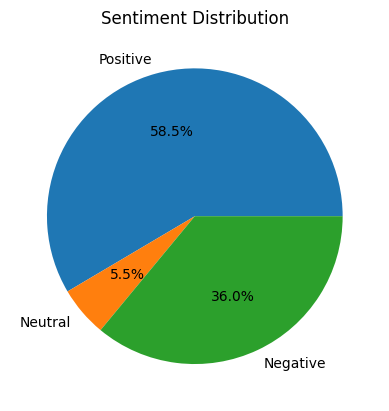

In [17]:
df_pandas = df_sentiment.groupBy("Sentiment").count().toPandas()
plt.pie(df_pandas['count'], labels=df_pandas['Sentiment'], autopct='%1.1f%%')
plt.title("Sentiment Distribution")
plt.show()

**Convert Spark DataFrame to Pandas plotting count plot**

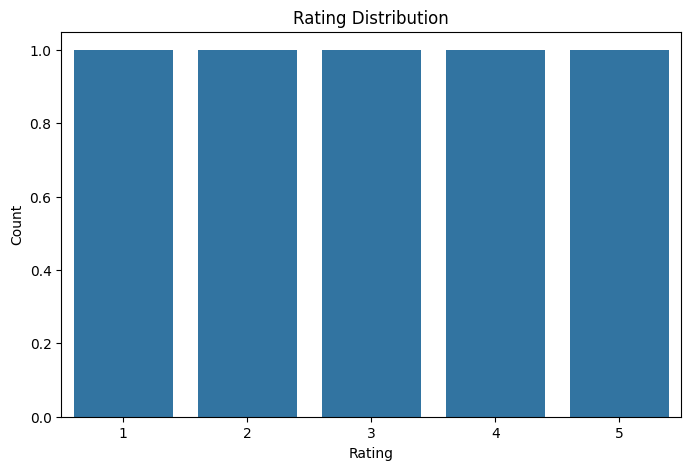

In [19]:
ratings_distribution = df_sentiment.groupBy("Rating").count().toPandas()

plt.figure(figsize=(8, 5))
sns.countplot(x="Rating", data=ratings_distribution)
plt.title('Rating Distribution')
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

**average rating by feedback channel**

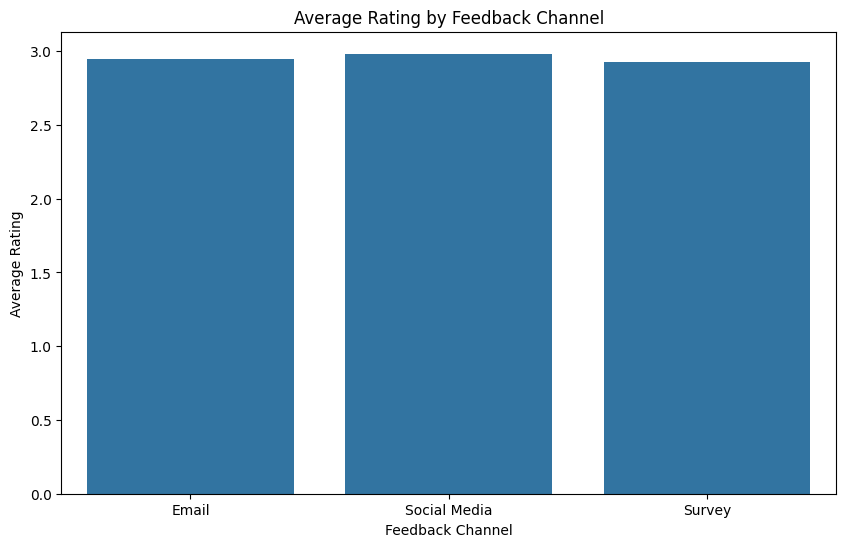

In [20]:
avg_rating = df_sentiment.groupBy("Feedback Channel").avg("Rating").toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_rating, x="Feedback Channel", y="avg(Rating)")
plt.title('Average Rating by Feedback Channel')
plt.xlabel("Feedback Channel")
plt.ylabel("Average Rating")
plt.show()

**Sentiment distribution**

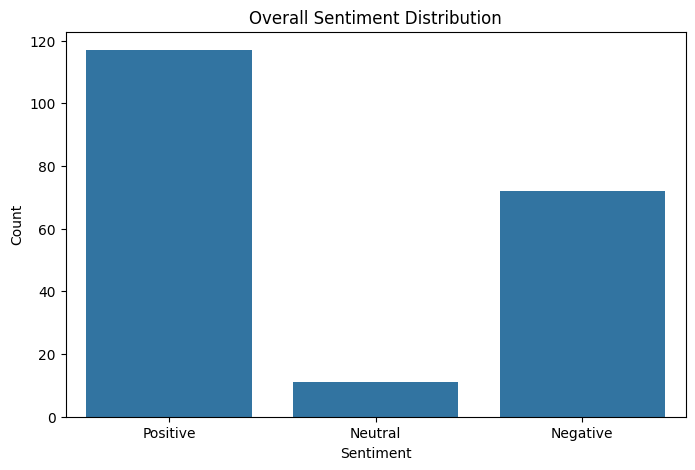

In [21]:
sentiment_distribution = df_sentiment.groupBy("Sentiment").count().toPandas()

plt.figure(figsize=(8, 5))
sns.barplot(x="Sentiment", y="count", data=sentiment_distribution)
plt.title("Overall Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

**Sentiment distribution by feedback channel**

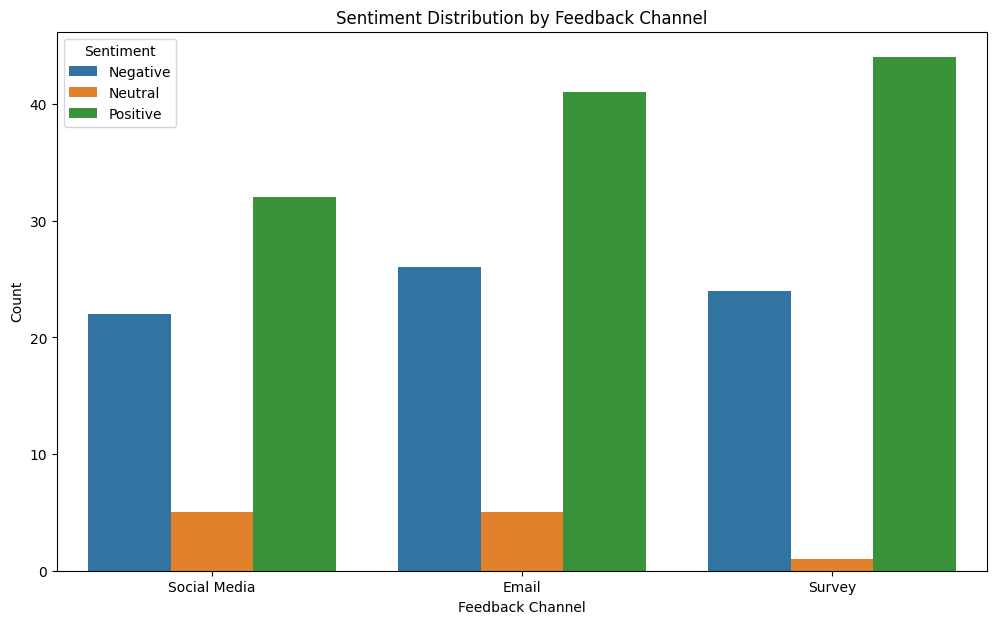

In [22]:
sentiment_channel = df_sentiment.groupBy("Feedback Channel", "Sentiment").count().toPandas()

plt.figure(figsize=(12, 7))
sns.barplot(data=sentiment_channel, x="Feedback Channel", y="count", hue="Sentiment")
plt.title('Sentiment Distribution by Feedback Channel')
plt.xlabel("Feedback Channel")
plt.ylabel("Count")
plt.show()

**Converting Spark DataFrame to Pandas and plotting boxplot**

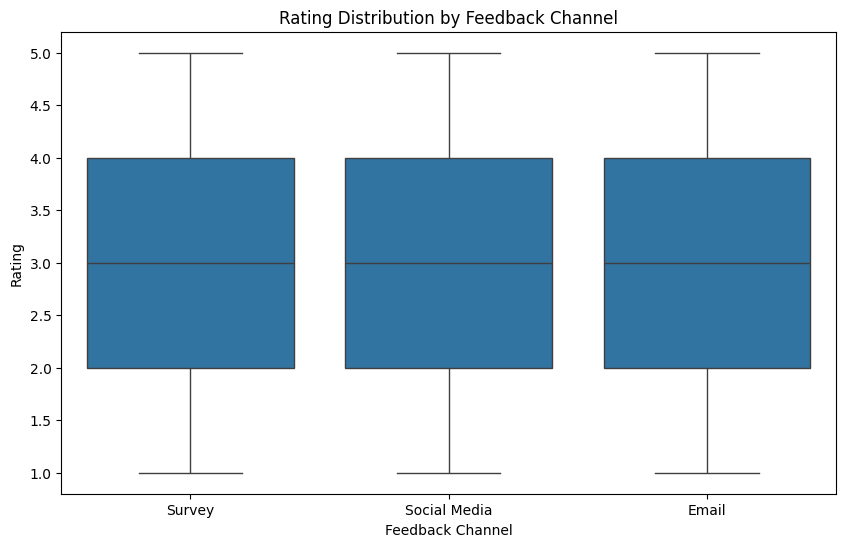

In [26]:
df_pandas = df_sentiment.select("Feedback Channel", "Rating").toPandas()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_pandas, x="Feedback Channel", y="Rating")
plt.title('Rating Distribution by Feedback Channel')
plt.xlabel("Feedback Channel")
plt.ylabel("Rating")
plt.show()

**Group feedback count by date**

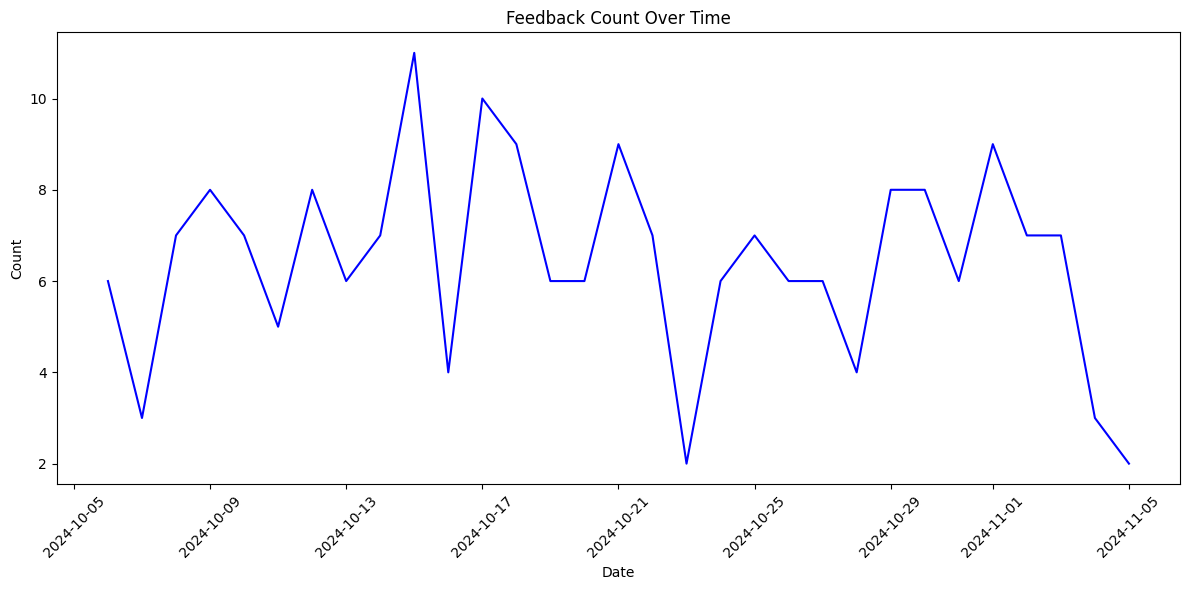

In [37]:
feedback_count_df = df_sentiment.groupBy("Date").count().orderBy("Date")

feedback_count_pd = feedback_count_df.toPandas()
feedback_count_pd['Date'] = pd.to_datetime(feedback_count_pd['Date'])  # Convert date for plotting

plt.figure(figsize=(12, 6))
plt.plot(feedback_count_pd["Date"], feedback_count_pd["count"], color="blue")
plt.title("Feedback Count Over Time")
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Filter positive feedback and group by channel**

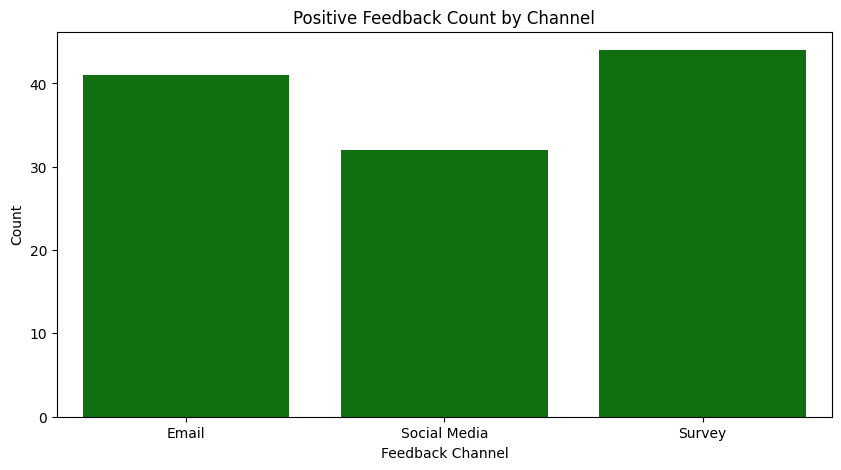

In [28]:
positive_feedback = df_sentiment.filter(df_sentiment.Sentiment == "Positive") \
    .groupBy("Feedback Channel").count().toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(x="Feedback Channel", y="count", data=positive_feedback, color="green")
plt.title("Positive Feedback Count by Channel")
plt.xlabel("Feedback Channel")
plt.ylabel("Count")
plt.show()

**Filter negative feedback and group by date**

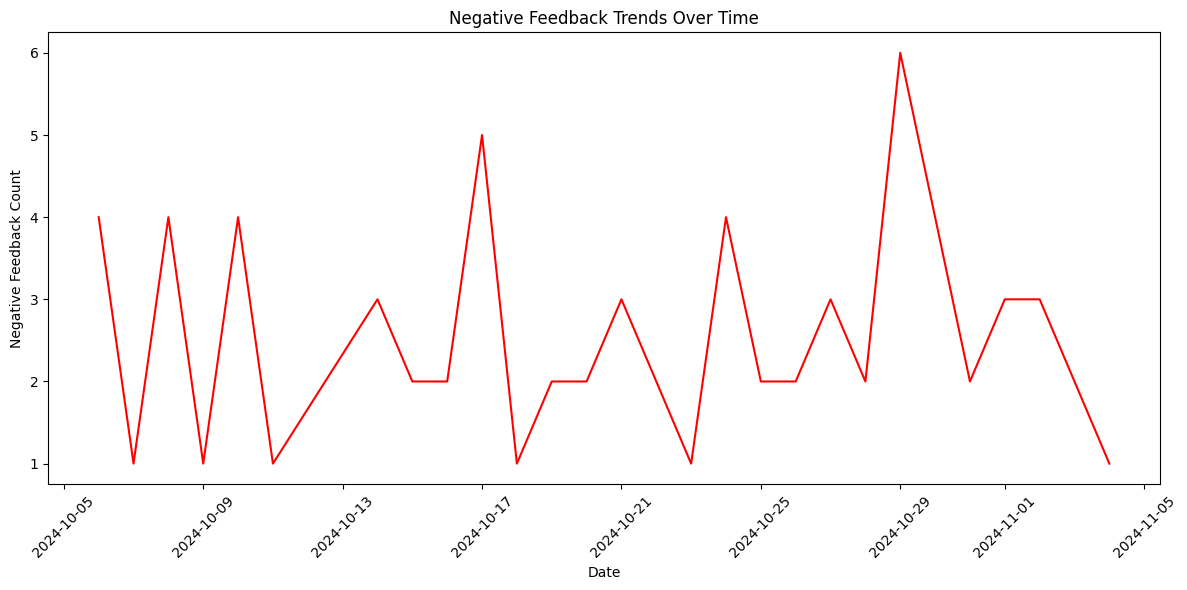

In [36]:

negative_feedback_df = df_sentiment.filter(df_sentiment.Sentiment == "Negative") \
                                   .groupBy("Date") \
                                   .count() \
                                   .orderBy("Date")

negative_feedback_pd = negative_feedback_df.toPandas()
negative_feedback_pd['Date'] = pd.to_datetime(negative_feedback_pd['Date'])  # Convert date for plotting

plt.figure(figsize=(12, 6))
plt.plot(negative_feedback_pd["Date"], negative_feedback_pd["count"], color="red")
plt.title("Negative Feedback Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Negative Feedback Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

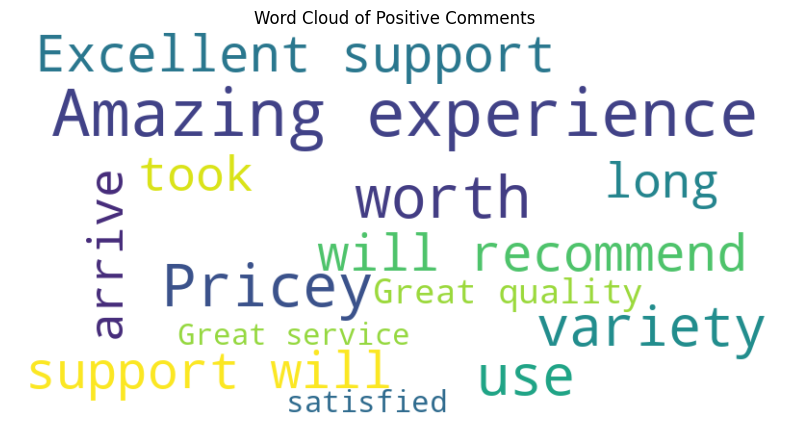

In [35]:
positive_comments = " ".join(df_sentiment.filter(df_sentiment.Sentiment == "Positive").select("Comment").rdd.flatMap(lambda x: x).collect())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(positive_comments)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Positive Comments")
plt.show()